In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

import spacy

import ssl
import socket

In [2]:
mails = pd.read_csv('CEAS_08.csv')
print(mails.head(3))

                                              sender  \
0                   Young Esposito <Young@iworld.de>   
1                       Mok <ipline's1983@icable.ph>   
2  Daily Top 10 <Karmandeep-opengevl@universalnet...   

                        receiver                             date  \
0    user4@gvc.ceas-challenge.cc  Tue, 05 Aug 2008 16:31:02 -0700   
1  user2.2@gvc.ceas-challenge.cc  Tue, 05 Aug 2008 18:31:03 -0500   
2  user2.9@gvc.ceas-challenge.cc  Tue, 05 Aug 2008 20:28:00 -1200   

                     subject  \
0  Never agree to be a loser   
1     Befriend Jenna Jameson   
2       CNN.com Daily Top 10   

                                                body  label  urls  
0  Buck up, your troubles caused by small dimensi...      1     1  
1  \nUpgrade your sex and pleasures with these te...      1     1  
2  >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...      1     1  


In [3]:
mails.drop_duplicates(subset=['subject', 'sender'],
                      keep='first',
                      inplace=True)

# print(mails.isnull().sum().sort_values())
mails.dropna(subset=['subject'], inplace=True)

In [4]:
def strip_for_mail(sender):
    start_symbol = '<'
    end_symbol = '>'
    if start_symbol in sender:
        start_index = sender.index(start_symbol) + 1
        end_index = sender.index(end_symbol)
        output = sender[start_index:end_index]
        return output
    else:
        return sender


mails['sender_mail'] = mails['sender'].apply(strip_for_mail)

In [5]:
mapping = {
    0: 'legit',
    1: 'malicious'
}

mails['label'] = mails['label'].map(mapping)

mails = mails[['sender_mail', 'subject', 'body', 'label']]
mails.columns = ['sender_mail', 'subject', 'body', 'phishing']

# print(mails.info())

In [6]:
# Na potrzeby obliczeń zmniejszamy
# mails = mails.iloc[:10000, :]
# print(mails.info())

In [7]:
print(mails.body[0])
def extract_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    matches = re.findall(url_pattern, text)

    return matches, len(matches)

mails[['extracted_urls', 'urls_count']] = mails['body'].apply(lambda x:
                                                              pd.Series(extract_urls(x)))
print(mails.head(3))


Buck up, your troubles caused by small dimension will soon be over!
Become a lover no woman will be able to resist!
http://whitedone.com/


come. Even as Nazi tanks were rolling down the streets, the dreamersphilosopher or a journalist. He was still not sure.I do the same.
                               sender_mail                    subject  \
0                          Young@iworld.de  Never agree to be a loser   
1                   ipline's1983@icable.ph     Befriend Jenna Jameson   
2  Karmandeep-opengevl@universalnet.psi.br       CNN.com Daily Top 10   

                                                body   phishing  \
0  Buck up, your troubles caused by small dimensi...  malicious   
1  \nUpgrade your sex and pleasures with these te...  malicious   
2  >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...  malicious   

                                      extracted_urls  urls_count  
0                            [http://whitedone.com/]           1  
1                        [http

## 1. Certyfikat SSL

In [8]:
def is_https(urls):
    if not urls:
        return 'None'
    
    if urls[0][:5] == 'https':
        return 'https'
    else:
        return 'http'
    

mails['protocol'] = mails['extracted_urls'].apply(is_https)

protocols = pd.CategoricalDtype(['None', 'http', 'https'],
                                ordered=True)

mails['protocol'] = mails['protocol'].astype(protocols)
# print(mails.head())

                               sender_mail  \
0                          Young@iworld.de   
1                   ipline's1983@icable.ph   
2  Karmandeep-opengevl@universalnet.psi.br   
3                        ivqrnai@pobox.com   
4         externalsep1@loanofficertool.com   

                                             subject  \
0                          Never agree to be a loser   
1                             Befriend Jenna Jameson   
2                               CNN.com Daily Top 10   
3  Re: svn commit: r619753 - in /spamassassin/tru...   
4                         SpecialPricesPharmMoreinfo   

                                                body   phishing  \
0  Buck up, your troubles caused by small dimensi...  malicious   
1  \nUpgrade your sex and pleasures with these te...  malicious   
2  >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...  malicious   
3  Would anyone object to removing .so from this ...      legit   
4  \nWelcomeFastShippingCustomerSupport\nhttp://7..

In [9]:
val_count = mails[['protocol', 'phishing']].value_counts()

data = {
    "malicious": {
        protocol: count for (protocol, phishing),
                    count in val_count.items() if phishing == 'malicious'
    },
    "legit": {
        protocol: count for (protocol, phishing),
                    count in val_count.items() if phishing == 'legit'
    }
}

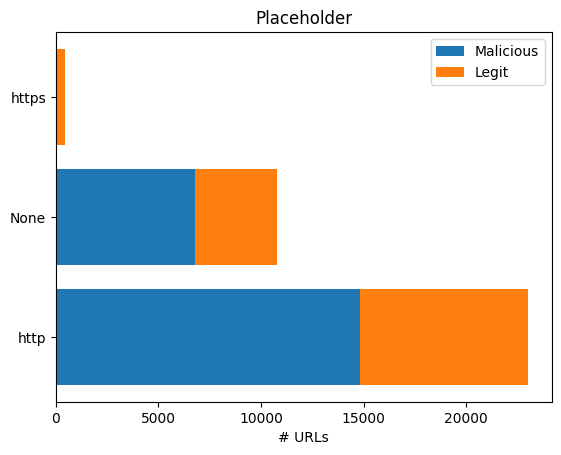

In [13]:

categories = list(data.keys())
protocols = list(data["malicious"].keys())
values_malicious = [data["malicious"][protocol] for protocol in protocols]
values_legit = [data["legit"][protocol] for protocol in protocols]

fig, ax = plt.subplots()
ax.barh(protocols, values_malicious, label='Malicious')
ax.barh(protocols, values_legit, label='Legit', left=values_malicious)

ax.set_xlabel('# URLs')
ax.set_title('Placeholder')

plt.legend()
plt.show()

## Autentyczność certyfikatu

In [40]:
def get_ssl_certificate(url):
    domain = url.split('//')[1].split('/')[0]
    print(domain)

    try:
        connection = socket.create_connection((domain, 443))
        context = ssl.create_default_context()
        with context.wrap_socket(connection, server_hostname=domain) as sock:
            certificate = sock.getpeercert()
            return shorten_certificate(certificate)
    except Exception as e:
        print(f"Error: {e}")
        return None


def shorten_certificate(cert):
    output_cert = {
        'Issuer': {
            'Common Name': cert['issuer'][2][0][1],
            'Organization': cert['issuer'][1][0][1],  
        },
        'Expiration_date': cert['notAfter']
    }
    return output_cert


url = 'https://aniagotuje.pl/'
certificate = get_ssl_certificate(url)
for k, v in certificate.items():
    print('{}: {}'.format(k, v))





aniagotuje.pl
Issuer: {'Common Name': 'R3', 'Organization': "Let's Encrypt"}
Expiration_date: Feb 27 16:34:55 2024 GMT


## Czarna lista słów

## Odnośniki przekierowywujące

## Ukrywane odnośniki

## Adres IP wewnątrz odnośnika

## Liczba odwiedzin witryny

## Wiek strony internetowej

## Adres e-mail nadawcy